# Advanced Time-Series Denoising Techniques for Industrial Sensor Data

This notebook implements various denoising techniques:
1. LOWESS (Locally Weighted Scatterplot Smoothing)
2. Adaptive LOWESS
3. Robust LOWESS
4. Adaptive Robust LOWESS (Hybrid)
5. Volumetric Regression (Peak Compression)
6. Kalman Filtering

Based on article by Athira Kaladharan

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from pykalman import KalmanFilter

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12

## Generate Synthetic Industrial Sensor Data

We'll create a realistic signal with:
- Underlying trend
- Random noise
- Outlier spikes (sensor glitches)
- Varying volatility regions

In [4]:
np.random.seed(42)

n_points = 500
t = np.linspace(0, 10, n_points)

# True underlying signal: combination of trends
true_signal = (
    50 + 
    10 * np.sin(2 * np.pi * t / 5) +  # slow oscillation
    5 * np.exp(-((t - 5) ** 2) / 2) +  # Gaussian bump
    0.5 * t  # linear trend
)

# Variable noise (higher in middle region)
noise_level = 1 + 3 * np.exp(-((t - 5) ** 2) / 4)
noise = noise_level * np.random.randn(n_points)

# Add outlier spikes
spike_indices = np.random.choice(n_points, size=15, replace=False)
spikes = np.zeros(n_points)
spikes[spike_indices] = np.random.choice([-1, 1], size=15) * np.random.uniform(8, 15, size=15)

# Final noisy signal
raw_signal = true_signal + noise + spikes
series = pd.Series(raw_signal)

print(f"Signal length: {n_points} points")
print(f"Number of outlier spikes: {len(spike_indices)}")

Signal length: 500 points
Number of outlier spikes: 15


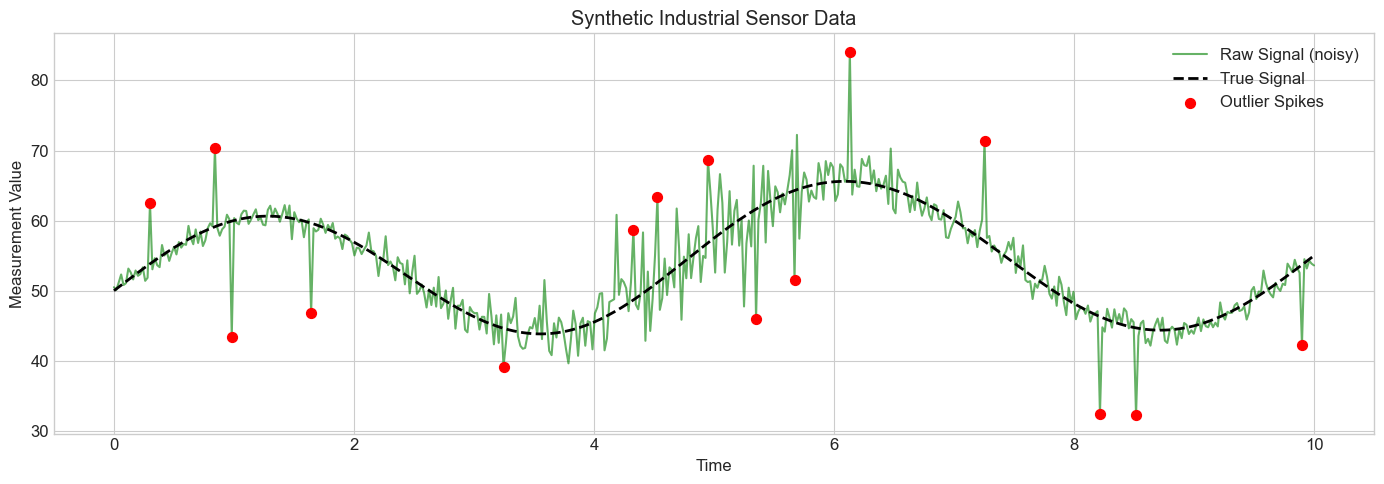

In [5]:
# Visualize raw data
plt.figure(figsize=(14, 5))
plt.plot(t, raw_signal, 'g-', alpha=0.6, label='Raw Signal (noisy)')
plt.plot(t, true_signal, 'k--', linewidth=2, label='True Signal')
plt.scatter(t[spike_indices], raw_signal[spike_indices], c='red', s=50, zorder=5, label='Outlier Spikes')
plt.xlabel('Time')
plt.ylabel('Measurement Value')
plt.title('Synthetic Industrial Sensor Data')
plt.legend()
plt.tight_layout()
plt.show()

---
## 1. LOWESS: The Foundation of Local Regression Smoothing

LOWESS (Locally Weighted Scatterplot Smoothing) fits many small local regressions.

For each point:
1. Select a neighborhood of nearby points
2. Assign weights based on distance (tricube kernel)
3. Fit a local linear regression
4. The fitted value at center is the smoothed output

**Formula:**
$$\hat{y}_i = \arg\min_\beta \sum_j w(t_j, t_i)(y_j - \beta_0 - \beta_1 t_j)^2$$

**Tricube kernel:**
$$w(t_j, t_i) = \left(1 - \left|\frac{t_j - t_i}{d_i}\right|^3\right)^3$$

In [6]:
# Basic LOWESS with different frac values
x = np.arange(len(series))

# Small frac = more responsive, less smoothing
lowess_small = lowess(series, x, frac=0.05, return_sorted=False)

# Medium frac
lowess_medium = lowess(series, x, frac=0.1, return_sorted=False)

# Large frac = more smoothing
lowess_large = lowess(series, x, frac=0.2, return_sorted=False)

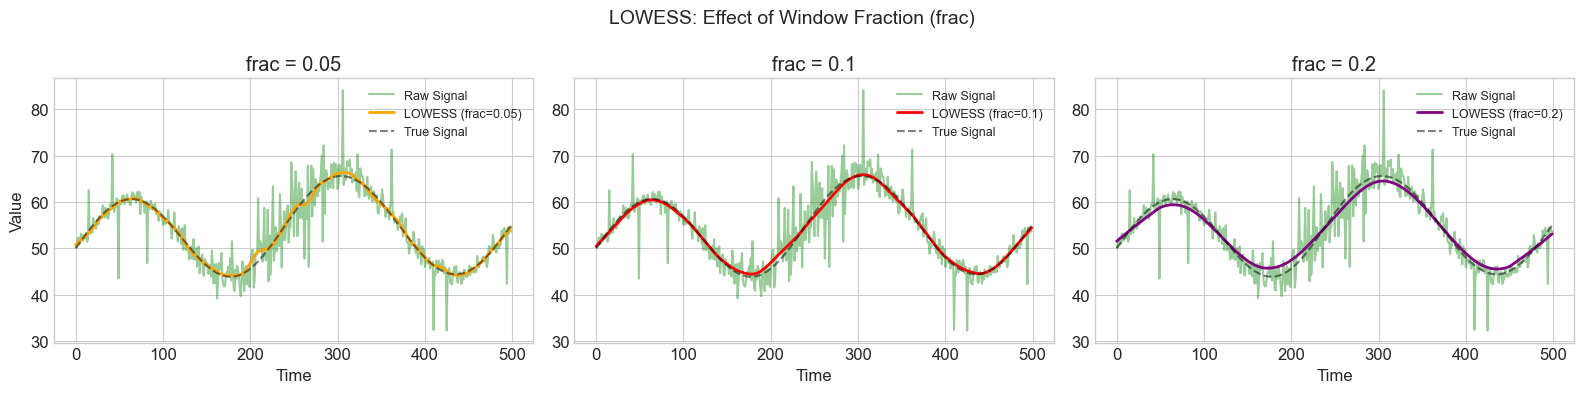

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

fracs = [0.05, 0.1, 0.2]
smoothed_list = [lowess_small, lowess_medium, lowess_large]
colors = ['orange', 'red', 'purple']

for ax, frac, smoothed, color in zip(axes, fracs, smoothed_list, colors):
    ax.plot(series.values, 'g-', alpha=0.4, label='Raw Signal')
    ax.plot(smoothed, color=color, linewidth=2, label=f'LOWESS (frac={frac})')
    ax.plot(true_signal, 'k--', alpha=0.5, label='True Signal')
    ax.set_title(f'frac = {frac}')
    ax.legend(fontsize=9)
    ax.set_xlabel('Time')

axes[0].set_ylabel('Value')
plt.suptitle('LOWESS: Effect of Window Fraction (frac)', fontsize=14)
plt.tight_layout()
plt.show()

**Key observations:**
- Small `frac` → responsive to local changes but retains noise
- Large `frac` → smoother but may lose important features
- Standard LOWESS is sensitive to outliers

---
## 2. Adaptive LOWESS: Dynamic Window Size

Real industrial signals are **non-stationary** - some regions are stable, others volatile.

**Core idea:** Adjust window size based on local variance:
$$frac_i = max\_frac - (max\_frac - min\_frac) \cdot \sqrt{var\_norm_i}$$

- High variance → smaller window → more responsive
- Low variance → larger window → more smoothing

In [8]:
def adaptive_lowess(series, min_frac=0.02, max_frac=0.2, var_window=20, robust_it=0):
    """
    Adaptive LOWESS with variance-based window sizing.
    
    Parameters:
    -----------
    series : pd.Series or np.array
        Input time series
    min_frac : float
        Minimum LOWESS fraction (for high-variance regions)
    max_frac : float
        Maximum LOWESS fraction (for low-variance regions)
    var_window : int
        Rolling window for variance calculation
    robust_it : int
        Number of robustness iterations (0 = no robustness)
    
    Returns:
    --------
    adaptive_smooth : np.array
        Smoothed signal
    adaptive_frac : np.array
        Fraction used at each point
    """
    if isinstance(series, np.ndarray):
        series = pd.Series(series)
    
    # Compute rolling variance
    rolling_var = series.rolling(window=var_window, center=True, min_periods=3).var()
    
    # Normalize variance (clip at 90th percentile)
    var_norm = (rolling_var / rolling_var.quantile(0.9)).clip(0, 1).fillna(0)
    
    # Compute adaptive fraction (square root for smooth transition)
    adaptive_frac = max_frac - (max_frac - min_frac) * np.sqrt(var_norm.values)
    adaptive_frac = np.clip(adaptive_frac, min_frac, max_frac)
    
    # Apply pointwise LOWESS
    adaptive_smooth = np.zeros_like(series.values, dtype=float)
    x = np.arange(len(series))
    
    for i in range(len(series)):
        f = adaptive_frac[i]
        half_window = max(3, int(f * len(series) / 2))
        start = max(0, i - half_window)
        end = min(len(series), i + half_window)
        
        y_local = series.iloc[start:end]
        
        if len(y_local) > 6:
            y_fit = lowess(
                y_local, x[start:end], 
                frac=max(0.05, f), 
                it=robust_it, 
                return_sorted=False
            )
            # Get the value at the center of the local window
            local_idx = i - start
            if local_idx < len(y_fit):
                adaptive_smooth[i] = y_fit[local_idx]
            else:
                adaptive_smooth[i] = y_fit[-1]
        else:
            adaptive_smooth[i] = series.iloc[i]
    
    return adaptive_smooth, adaptive_frac

In [9]:
# Apply adaptive LOWESS
adaptive_smooth, adaptive_frac = adaptive_lowess(series, min_frac=0.02, max_frac=0.2, var_window=20)

print(f"Fraction range: {adaptive_frac.min():.3f} to {adaptive_frac.max():.3f}")

Fraction range: 0.020 to 0.169


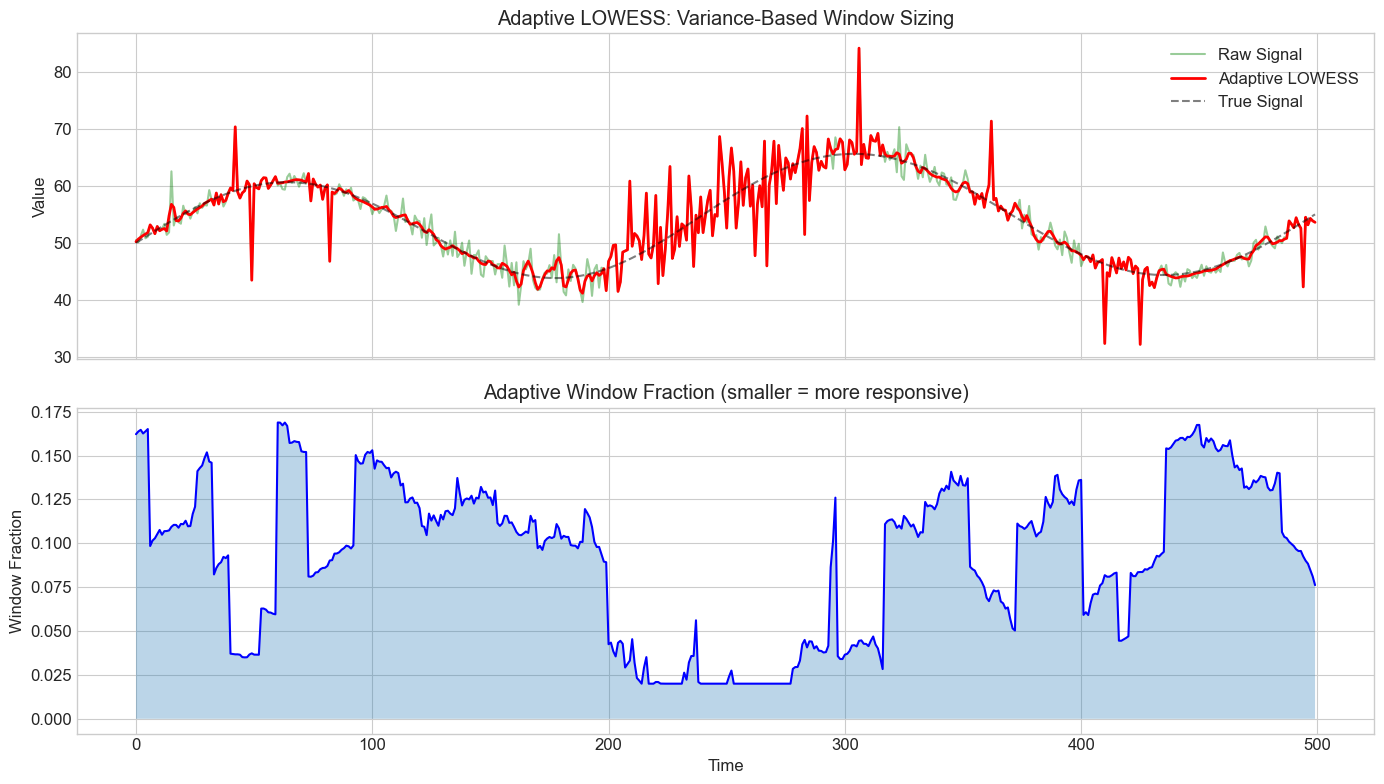

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Plot smoothed signal
axes[0].plot(series.values, 'g-', alpha=0.4, label='Raw Signal')
axes[0].plot(adaptive_smooth, 'r-', linewidth=2, label='Adaptive LOWESS')
axes[0].plot(true_signal, 'k--', alpha=0.5, label='True Signal')
axes[0].set_ylabel('Value')
axes[0].set_title('Adaptive LOWESS: Variance-Based Window Sizing')
axes[0].legend()

# Plot adaptive fraction
axes[1].plot(adaptive_frac, 'b-', linewidth=1.5)
axes[1].fill_between(range(len(adaptive_frac)), adaptive_frac, alpha=0.3)
axes[1].set_ylabel('Window Fraction')
axes[1].set_xlabel('Time')
axes[1].set_title('Adaptive Window Fraction (smaller = more responsive)')

plt.tight_layout()
plt.show()

---
## 3. Robust LOWESS: Handling Outliers

Robust LOWESS iteratively **reweights points based on residuals**.

Points far from the local fit (large residuals) receive less weight in the next iteration.

The `it` parameter specifies robustness iterations (typically 3-5).

In [11]:
# Standard LOWESS vs Robust LOWESS
lowess_standard = lowess(series, x, frac=0.1, it=0, return_sorted=False)
lowess_robust = lowess(series, x, frac=0.1, it=5, return_sorted=False)

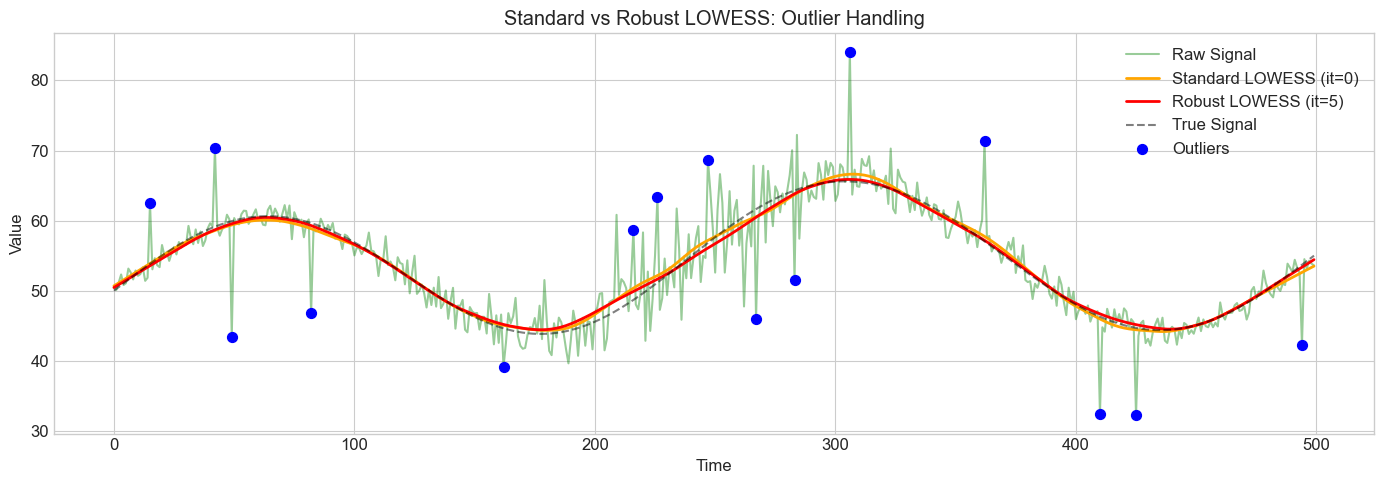

In [12]:
plt.figure(figsize=(14, 5))
plt.plot(series.values, 'g-', alpha=0.4, label='Raw Signal')
plt.plot(lowess_standard, 'orange', linewidth=2, label='Standard LOWESS (it=0)')
plt.plot(lowess_robust, 'red', linewidth=2, label='Robust LOWESS (it=5)')
plt.plot(true_signal, 'k--', alpha=0.5, label='True Signal')
plt.scatter(spike_indices, series.values[spike_indices], c='blue', s=50, zorder=5, label='Outliers')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Standard vs Robust LOWESS: Outlier Handling')
plt.legend()
plt.tight_layout()
plt.show()

---
## 4. Adaptive Robust LOWESS (Hybrid Approach)

Combines:
- **Adaptive variance-based windowing**
- **Robust reweighting for outliers**

Best for highly non-stationary signals with spikes.

In [13]:
# Adaptive Robust LOWESS
adaptive_robust_smooth, _ = adaptive_lowess(
    series, 
    min_frac=0.02, 
    max_frac=0.2, 
    var_window=20,
    robust_it=5  # Enable robustness
)

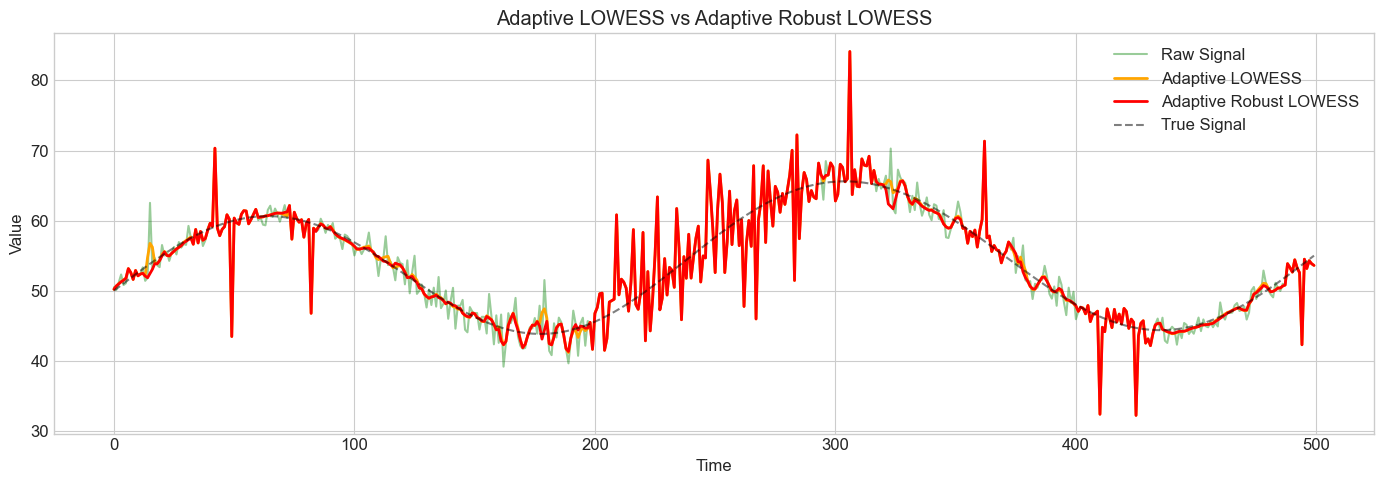

In [14]:
plt.figure(figsize=(14, 5))
plt.plot(series.values, 'g-', alpha=0.4, label='Raw Signal')
plt.plot(adaptive_smooth, 'orange', linewidth=2, label='Adaptive LOWESS')
plt.plot(adaptive_robust_smooth, 'red', linewidth=2, label='Adaptive Robust LOWESS')
plt.plot(true_signal, 'k--', alpha=0.5, label='True Signal')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Adaptive LOWESS vs Adaptive Robust LOWESS')
plt.legend()
plt.tight_layout()
plt.show()

---
## 5. Volumetric Regression: Selective Peak Compression

Sometimes peaks remain after denoising - not noise, but physically unrealistic excursions.

**Algorithm:**
1. Get baseline trend with LOWESS
2. Compute deviation from baseline
3. Use IQR-based thresholds to detect peaks
4. Compress only the amplitude of peaks

In [15]:
def volumetric_compression(series, baseline_frac=0.07, iqr_window=15, 
                           iqr_multiplier=0.5, compression_strength=0.4):
    """
    Selective peak compression using IQR-based thresholds.
    
    Parameters:
    -----------
    series : pd.Series or np.array
        Input time series
    baseline_frac : float
        LOWESS fraction for baseline extraction
    iqr_window : int
        Rolling window for IQR calculation
    iqr_multiplier : float
        Multiplier for IQR thresholds
    compression_strength : float
        0 = flatten peaks, 1 = no change
    
    Returns:
    --------
    compressed : np.array
        Peak-compressed signal
    baseline : np.array
        Extracted baseline
    peak_mask : np.array
        Boolean mask of detected peaks
    """
    if isinstance(series, np.ndarray):
        series = pd.Series(series)
    
    x = np.arange(len(series))
    
    # Get baseline using LOWESS
    baseline = lowess(series, x, frac=baseline_frac, return_sorted=False)
    
    # Compute deviation
    deviation = series.values - baseline
    deviation_series = pd.Series(deviation)
    
    # Rolling IQR-based thresholds
    q1 = deviation_series.rolling(iqr_window, min_periods=1, center=True).quantile(0.25)
    q3 = deviation_series.rolling(iqr_window, min_periods=1, center=True).quantile(0.75)
    iqr = q3 - q1
    
    upper = q3 + iqr_multiplier * iqr
    lower = q1 - iqr_multiplier * iqr
    
    # Detect peaks
    peak_mask = (deviation > upper.values) | (deviation < lower.values)
    
    # Compress peaks
    compressed = series.values.copy()
    compressed[peak_mask] = baseline[peak_mask] + compression_strength * deviation[peak_mask]
    
    return compressed, baseline, peak_mask

In [16]:
# Apply volumetric compression
compressed, baseline, peak_mask = volumetric_compression(
    series, 
    baseline_frac=0.07, 
    iqr_multiplier=0.5, 
    compression_strength=0.4
)

print(f"Detected {peak_mask.sum()} peak points ({100*peak_mask.mean():.1f}% of data)")

Detected 95 peak points (19.0% of data)


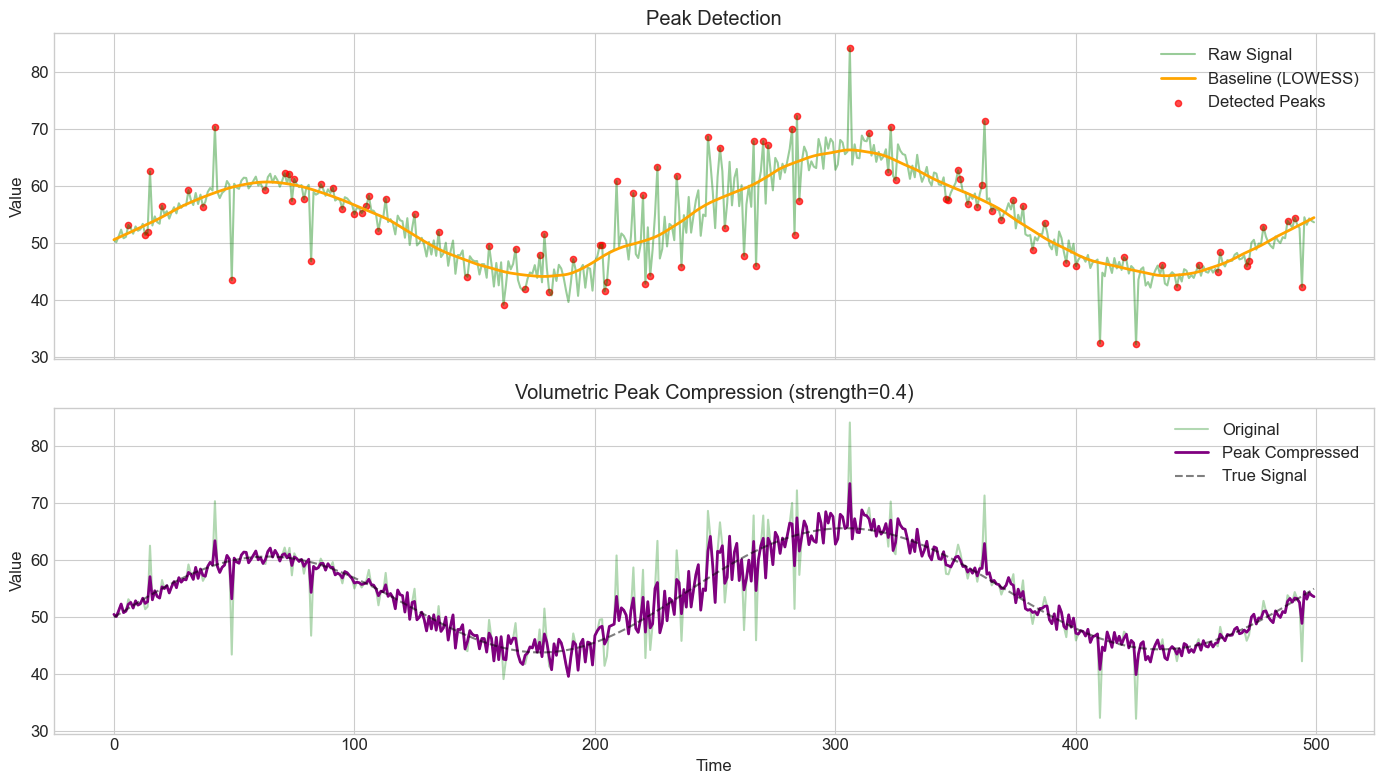

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Original vs compressed
axes[0].plot(series.values, 'g-', alpha=0.4, label='Raw Signal')
axes[0].plot(baseline, 'orange', linewidth=2, label='Baseline (LOWESS)')
axes[0].scatter(np.where(peak_mask)[0], series.values[peak_mask], 
                c='red', s=20, alpha=0.7, label='Detected Peaks')
axes[0].set_ylabel('Value')
axes[0].set_title('Peak Detection')
axes[0].legend()

# Compressed signal
axes[1].plot(series.values, 'g-', alpha=0.3, label='Original')
axes[1].plot(compressed, 'purple', linewidth=2, label='Peak Compressed')
axes[1].plot(true_signal, 'k--', alpha=0.5, label='True Signal')
axes[1].set_ylabel('Value')
axes[1].set_xlabel('Time')
axes[1].set_title('Volumetric Peak Compression (strength=0.4)')
axes[1].legend()

plt.tight_layout()
plt.show()

---
## 6. Kalman Filtering: Model-Based Denoising

Unlike data-driven LOWESS, Kalman Filter is **model-based**.

Assumes a dynamic system:
$$x_t = A x_{t-1} + w_t \quad \text{(state transition)}$$
$$y_t = H x_t + v_t \quad \text{(observation)}$$

where $w_t$, $v_t$ are Gaussian noise terms.

**Tuning:**
- High `transition_covariance` → more responsive
- High `observation_covariance` → smoother (trusts model more)

In [18]:
def apply_kalman_filter(series, transition_cov=0.1, observation_cov=1.0):
    """
    Apply 1D Kalman filter for denoising.
    
    Parameters:
    -----------
    series : array-like
        Input time series
    transition_cov : float
        Process noise covariance (higher = more responsive)
    observation_cov : float
        Measurement noise covariance (higher = smoother)
    
    Returns:
    --------
    smoothed : np.array
        Kalman-smoothed signal
    """
    if isinstance(series, pd.Series):
        series = series.values
    
    kf = KalmanFilter(
        initial_state_mean=series[0],
        n_dim_obs=1, 
        n_dim_state=1,
        transition_matrices=np.array([[1]]),
        observation_matrices=np.array([[1]]),
        transition_covariance=np.array([[transition_cov]]),
        observation_covariance=np.array([[observation_cov]])
    )
    
    # Reshape for pykalman
    observations = series.reshape(-1, 1)
    
    # Use smoothing (forward-backward pass)
    smoothed_state_means, _ = kf.smooth(observations)
    
    return smoothed_state_means.flatten()

In [19]:
# Apply Kalman filter with different parameters
kalman_responsive = apply_kalman_filter(series, transition_cov=1.0, observation_cov=1.0)
kalman_balanced = apply_kalman_filter(series, transition_cov=0.1, observation_cov=1.0)
kalman_smooth = apply_kalman_filter(series, transition_cov=0.01, observation_cov=1.0)

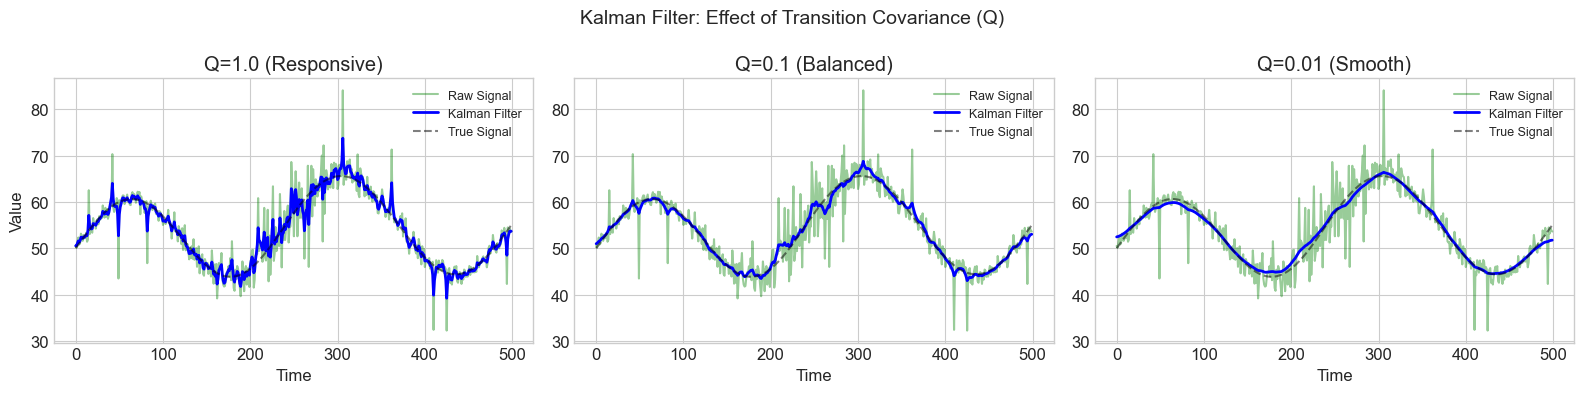

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

params = [
    (kalman_responsive, 'Q=1.0 (Responsive)'),
    (kalman_balanced, 'Q=0.1 (Balanced)'),
    (kalman_smooth, 'Q=0.01 (Smooth)')
]

for ax, (smoothed, title) in zip(axes, params):
    ax.plot(series.values, 'g-', alpha=0.4, label='Raw Signal')
    ax.plot(smoothed, 'b-', linewidth=2, label='Kalman Filter')
    ax.plot(true_signal, 'k--', alpha=0.5, label='True Signal')
    ax.set_title(title)
    ax.legend(fontsize=9)
    ax.set_xlabel('Time')

axes[0].set_ylabel('Value')
plt.suptitle('Kalman Filter: Effect of Transition Covariance (Q)', fontsize=14)
plt.tight_layout()
plt.show()

---
## 7. Combining Kalman with LOWESS

Use **Adaptive LOWESS output** as the observation for **Kalman Filtering**:
- Adaptive trend tracking (from LOWESS)
- Statistical noise control (from Kalman)

In [21]:
# Hybrid: Kalman on Adaptive LOWESS output
hybrid_kalman = apply_kalman_filter(
    adaptive_robust_smooth, 
    transition_cov=0.05, 
    observation_cov=0.5
)

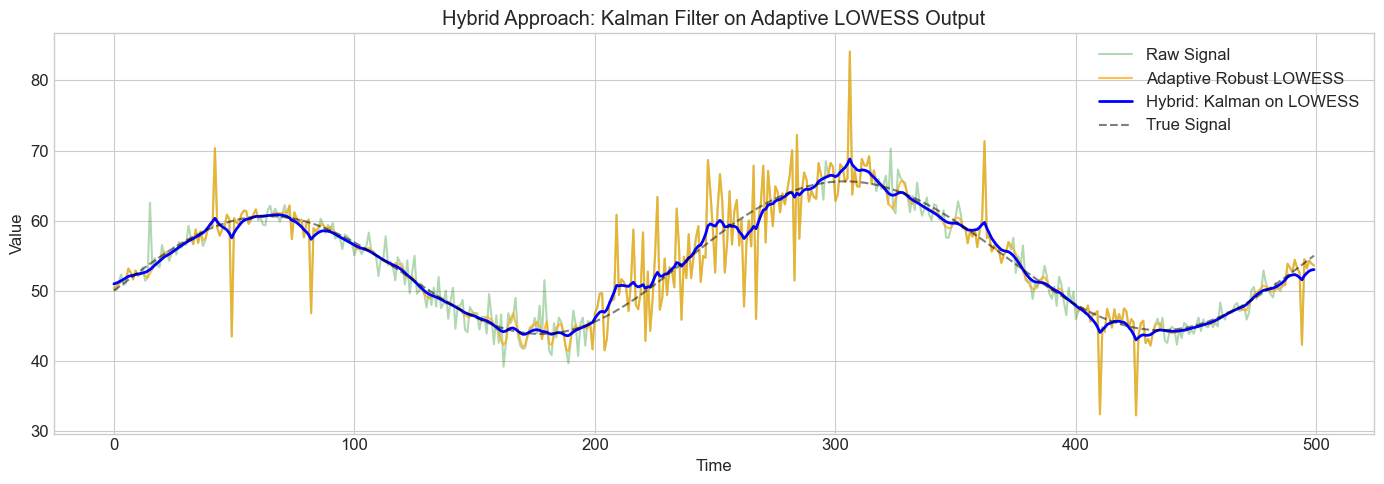

In [22]:
plt.figure(figsize=(14, 5))
plt.plot(series.values, 'g-', alpha=0.3, label='Raw Signal')
plt.plot(adaptive_robust_smooth, 'orange', linewidth=1.5, alpha=0.7, label='Adaptive Robust LOWESS')
plt.plot(hybrid_kalman, 'blue', linewidth=2, label='Hybrid: Kalman on LOWESS')
plt.plot(true_signal, 'k--', alpha=0.5, label='True Signal')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Hybrid Approach: Kalman Filter on Adaptive LOWESS Output')
plt.legend()
plt.tight_layout()
plt.show()

---
## 8. Comparative Summary

| Method | Handles Noise | Handles Outliers | Preserves Peaks | Adapts to Variance | Suitable For |
|--------|---------------|------------------|-----------------|-------------------|-------------|
| LOWESS | ✓ | △ Moderate | ✗ | ✗ | Smooth trends |
| Robust LOWESS | ✓✓ | ✓ | △ Partial | ✗ | Spiky signals |
| Adaptive LOWESS | ✓✓ | ✓ | ✓ | ✓ | Non-stationary series |
| Volumetric Regression | △ | ✓ | ✓ | ✓ | Peak-heavy signals |
| Kalman Filter | ✓✓ | △ | ✓ | ✓ | Model-based filtering |

In [23]:
# Compute reconstruction error (RMSE) for each method
def rmse(predicted, actual):
    return np.sqrt(np.mean((predicted - actual) ** 2))

methods = {
    'Raw Signal': series.values,
    'LOWESS (frac=0.1)': lowess_medium,
    'Robust LOWESS': lowess_robust,
    'Adaptive LOWESS': adaptive_smooth,
    'Adaptive Robust LOWESS': adaptive_robust_smooth,
    'Volumetric Compression': compressed,
    'Kalman Filter': kalman_balanced,
    'Hybrid (Kalman+LOWESS)': hybrid_kalman
}

print("Reconstruction Error (RMSE vs True Signal):")
print("=" * 50)
for name, smoothed in methods.items():
    error = rmse(smoothed, true_signal)
    print(f"{name:30} : {error:.4f}")

Reconstruction Error (RMSE vs True Signal):
Raw Signal                     : 3.1827
LOWESS (frac=0.1)              : 0.5005
Robust LOWESS                  : 0.5271
Adaptive LOWESS                : 2.9656
Adaptive Robust LOWESS         : 2.9586
Volumetric Compression         : 1.8712
Kalman Filter                  : 0.9231
Hybrid (Kalman+LOWESS)         : 0.9124


---
## 9. Final Visualization: All Methods Compared

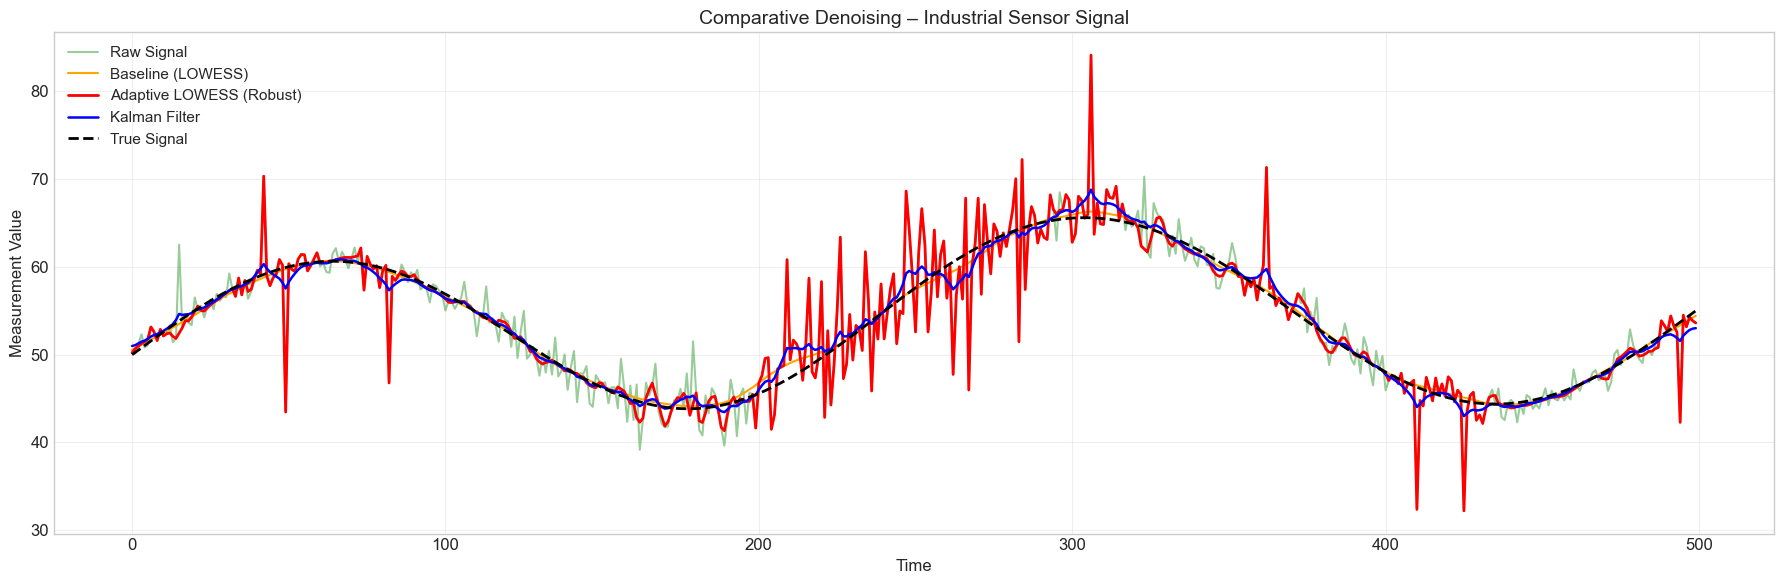

In [24]:
plt.figure(figsize=(18, 6))

plt.plot(series.values, label="Raw Signal", alpha=0.4, color="green")
plt.plot(baseline, label="Baseline (LOWESS)", color="orange", linewidth=1.5)
plt.plot(adaptive_robust_smooth, label="Adaptive LOWESS (Robust)", color="red", linewidth=2)
plt.plot(kalman_balanced, label="Kalman Filter", color="blue", linewidth=1.8)
plt.plot(true_signal, label="True Signal", color="black", linestyle="--", linewidth=2)

plt.legend(loc='upper left', fontsize=11)
plt.title("Comparative Denoising – Industrial Sensor Signal", fontsize=14)
plt.xlabel("Time")
plt.ylabel("Measurement Value")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## 10. Practical Tuning Workflow

1. **Start with baseline LOWESS** to understand trend
2. **Add robustness** (`it > 3`) to handle spikes
3. **Incorporate adaptive variance windowing** if signal volatility changes
4. **Use volumetric compression** only if peaks dominate behavior
5. **Layer Kalman Filtering** for state estimation or predictive models

---
## Key Takeaways

- **LOWESS** is an excellent general-purpose smoother for capturing slow trends
- **Robust LOWESS** handles outliers effectively
- **Adaptive LOWESS** dynamically tunes smoothing for changing variance
- **Volumetric Regression** selectively compresses peaks, preserving realism
- **Kalman Filters** combine physical intuition and statistical inference

For industrial process data — such as kiln O₂, NOx emissions, furnace pressures, or cooling water flow — these hybrid techniques can dramatically improve signal clarity, fault detection, and predictive stability.

---

**No single filter is perfect.** The best denoising pipelines blend statistical adaptivity, robustness, and physical interpretability.